In [45]:
import pandas as pd
import numpy as np

import json
from rdkit import Chem
import pandas as pd
import itertools
import sys
from tqdm import tqdm 
from itertools import chain, combinations
import sys
import multiprocessing as mp
from functools import partial
from collections import Counter
tqdm.pandas()
sys.path.append('../')
from common import *

# 9-1之后去kcat预测文件夹下准确预测文件，并使用不同方法预测

## 把模型的gpr匹配到rxndb_total_info_to_model中，然后生成预测文件去预测

In [46]:
yeast870_path =  '../../../Data/model/yeast-GEM902.yml'

cut_off = 0.3
num = 50 
rxnmapper_cutoff = 0.2

cut_off_path = f'../../../Results/yeast8_recovery/top{num}_{cut_off}/'
rxndb_total_info_to_model_path = cut_off_path + f'rxndb_total_info_to_model_top{num}_{cut_off}_{rxnmapper_cutoff}.csv'
yeast8_reaction_in_rxndb_json = cut_off_path + f'yeast8_reaction_in_rxndb_top{num}_{cut_off}_{rxnmapper_cutoff}.json'




yeast8_recovery_unikp_path = f'../../../Results/kcat_km_predict/yeast8_recovery_{rxnmapper_cutoff}_unikp.csv'
yeast8_recovery_esp_path = f'../../../Results/kcat_km_predict/sequence_smiles_prepare_yeast8_recovery_{rxnmapper_cutoff}_ESP.csv'
yeast8_recovery_enzRANK_path = f'../../../Results/kcat_km_predict/sequence_smiles_prepare_yeast8_recovery_{rxnmapper_cutoff}_enzRANK.csv'
yeast8_recovery_puepp_path = f'../../../Results/kcat_km_predict/sequence_smiles_prepare_yeast8_recovery_{rxnmapper_cutoff}_enzRANK.csv'
yeast8_recovery_prosmith_drop_path = f'../../../Results/kcat_km_predict/sequence_smiles_prepare_yeast8_recovery_{rxnmapper_cutoff}_drop_prosmith.csv'
yeast8_recovery_prosmith_path = f'../../../Results/kcat_km_predict/sequence_smiles_prepare_yeast8_recovery_{rxnmapper_cutoff}.csv'
rxndb_total_info_to_model_path


figs7_path = '../../../Results/Figures/figs7.pdf'

In [47]:
def get_genelist_for_realst(realst,model):
    gene_list = []
    for rea in realst:
        gene_list+=str(model.reactions.get_by_id(rea).gene_reaction_rule).replace('(','').replace(')','').replace(' and ',' ').replace(' or ',' ').split(' ')
    gene_list = list(set(gene_list))
    return gene_list

In [48]:
model = cobra.io.load_yaml_model(yeast870_path)

In [49]:
rxndb_total_info_to_model = pd.read_csv(f'../../../Results/kcat_km_predict/sequence_smiles_prepare_yeast8_recovery_{rxnmapper_cutoff}.csv')
print(rxndb_total_info_to_model.shape)

(844169, 9)


# ProSmith

In [50]:
drop_result = pd.read_csv(yeast8_recovery_prosmith_drop_path)
# rxndb_total_info_to_model = rxndb_total_info_to_model[['rea_id','gene','met_id','PU_EPP_score']]
drop_result.head()

result_dict = {}
for index,row in drop_result.iterrows():
    result_dict[row['SMILES']+'__'+row['Protein sequence']] = row['predict output']

In [51]:
rxndb_total_info_to_model = pd.read_csv(yeast8_recovery_prosmith_path)
rxndb_total_info_to_model = rxndb_total_info_to_model[['rea_id','gene','SMILES','Sequence','met_id']]

def get_prosmith_score(row):
    key = f"{row['SMILES']}__{row['Sequence']}"
    return result_dict.get(key, None)  # 如果key不存在，返回None或其它默认值

rxndb_total_info_to_model['prosmith_score'] = rxndb_total_info_to_model.apply(get_prosmith_score, axis=1)

In [52]:
print(rxndb_total_info_to_model.shape)
rxndb_total_info_to_model = rxndb_total_info_to_model[~rxndb_total_info_to_model['prosmith_score'].isna()]
print(rxndb_total_info_to_model.shape)

# 读取 JSON 文件
with open(yeast8_reaction_in_rxndb_json, "r") as f:
    yeast8_reaction_in_rxndb = json.load(f)

print(yeast8_reaction_in_rxndb)

reaID2modelreaID = {}
for model_reaction, rea_ids in tqdm(yeast8_reaction_in_rxndb.items(), total=len(yeast8_reaction_in_rxndb)):
    for rea_id in rea_ids:
        if rea_id in reaID2modelreaID:
            reaID2modelreaID[rea_id].append(model_reaction)
        else:
            reaID2modelreaID[rea_id] = []
            reaID2modelreaID[rea_id].append(model_reaction)

rxndb_total_info_to_model['model_reaction'] = None
for index,row in tqdm(rxndb_total_info_to_model.iterrows(),total=len(rxndb_total_info_to_model)):
    if row['rea_id'].split('_')[0] in reaID2modelreaID:
        rxndb_total_info_to_model.at[index,'model_reaction'] = reaID2modelreaID[row['rea_id'].split('_')[0]]

rxndb_total_info_to_model = rxndb_total_info_to_model[~rxndb_total_info_to_model['model_reaction'].isna()]
print(rxndb_total_info_to_model.shape)
rxndb_total_info_to_model = rxndb_total_info_to_model[rxndb_total_info_to_model['model_reaction'].apply(lambda x:len(x)>0)]
print(rxndb_total_info_to_model.shape)

(844169, 6)
(844169, 6)
{'r_0003': ['rxn8630', 'rxn921'], 'r_0007': ['rxn1197'], 'r_0012': ['rxn61173', 'rxn83181', 'rxn24047'], 'r_0013': [], 'r_0014': ['rxn7244'], 'r_0015': ['rxn19174', 'rxn22553'], 'r_0016': ['rxn96080'], 'r_0017': ['rxn37218'], 'r_0018': ['rxn642'], 'r_0019': ['rxn126140', 'rxn40298', 'rxn5013', 'rxn2078', 'rxn3362'], 'r_0020': [], 'r_0021': ['rxn23562'], 'r_0022': ['rxn1156'], 'r_0023': ['rxn43191', 'rxn11167'], 'r_0024': ['rxn14638', 'rxn24033'], 'r_0025': ['rxn14638', 'rxn24033'], 'r_0026': ['rxn631'], 'r_0027': ['rxn44683', 'rxn30684', 'rxn11165'], 'r_0028': ['rxn78546'], 'r_0029': ['rxn59146', 'rxn26386'], 'r_0030': ['rxn59146', 'rxn26386'], 'r_0034': ['rxn30665', 'rxn14800'], 'r_0035': ['rxn30668', 'rxn14799'], 'r_0036': ['rxn30667', 'rxn14798'], 'r_0037': ['rxn44946', 'rxn30669'], 'r_0038': ['rxn14551'], 'r_0039': ['rxn1306'], 'r_0040': ['rxn64571'], 'r_0041': ['rxn18210', 'rxn22147', 'rxn311', 'rxn2288'], 'r_0042': [], 'r_0043': ['rxn33462', 'rxn108296', '

100%|██████████| 844169/844169 [00:36<00:00, 23174.51it/s]


(127872, 7)
(127872, 7)


In [53]:
result = {'rea_id':[],
          'modelreaID':[],
          'met_id':[],
          'true_kcat_tmp':[],
          'all_kcat_tmp':[],
          }
for reaID,modelreaIDs in tqdm(reaID2modelreaID.items(),total=len(reaID2modelreaID)):
    # print(reaID,modelreaIDs)
    df_tmp = rxndb_total_info_to_model[rxndb_total_info_to_model['rea_id'].apply(lambda x:x.split('_')[0]==reaID)]
    genelist_tmp = get_genelist_for_realst(modelreaIDs,model)
    met_list_tmp = list(set(df_tmp['met_id'].to_list()))
    for met in met_list_tmp:
        df_tmp_tmp = df_tmp[df_tmp['met_id']==met]
        true_kcat_tmp = df_tmp_tmp[df_tmp_tmp['gene'].isin(genelist_tmp)]['prosmith_score'].to_list()
        all_kcat_tmp = df_tmp_tmp['prosmith_score'].to_list()

        result['rea_id'].append(reaID)
        result['modelreaID'].append(modelreaIDs)
        result['met_id'].append(met)
        result['true_kcat_tmp'].append(true_kcat_tmp)
        result['all_kcat_tmp'].append(all_kcat_tmp)

# for index,row in rxndb_total_info_to_model.iterrow():

100%|██████████| 2128/2128 [01:31<00:00, 23.27it/s]


In [54]:
result_df = pd.DataFrame(result)
result_df['modelreaID'] = result_df['modelreaID'].apply(lambda x:str(x))
result_df = result_df.drop_duplicates(subset=['modelreaID', 'met_id'])
print(result_df.shape)
result_df = result_df[result_df['true_kcat_tmp'].apply(lambda x:len(x)>0)]
print(result_df.shape)
result_df.reset_index(inplace=True)

# 添加一列，计算 all_kcat_tmp 的最大值
result_df['max_all_kcat_tmp'] = result_df['all_kcat_tmp'].apply(max)
# 根据 max_all_kcat_tmp 降序排序
result_df = result_df.sort_values(by='max_all_kcat_tmp', ascending=False).reset_index(drop=True)

(1286, 5)
(880, 5)


In [55]:
# 修正排名函数，使用近似比较解决浮点精度问题
def calculate_ranks_approx(true_values, all_values, order="desc", tolerance=1e-20):
    ascending = True if order == "asc" else False
    sorted_values = sorted(all_values, reverse=not ascending)
    ranks = [
        next((i + 1 for i, val in enumerate(sorted_values) if abs(val - true_val) < tolerance), None)
        for true_val in true_values
    ]
    return ranks

# 计算每行的排名，并加入新列
ranking_order = "desc"  # 指定排名方式 ("desc" 从大到小, "asc" 从小到大)
result_df["true_kcat_ranks"] = result_df.apply(
    lambda row: calculate_ranks_approx(row["true_kcat_tmp"], row["all_kcat_tmp"], order=ranking_order), axis=1
)

result_df.head(3)

,index,rea_id,modelreaID,met_id,true_kcat_tmp,all_kcat_tmp,max_all_kcat_tmp,true_kcat_ranks
0,1147,rxn9887,['r_0961'],s_1399,"[0.99747545, 0.15653785, 0.124793306, 0.995159...","[0.14006446, 0.0035960362, 0.38108695, 0.01509...",0.997475,"[1, 40, 58, 2, 14]"
1,562,rxn96971,['r_0443'],s_0721,[0.8544541],"[0.86466765, 0.98998404, 0.7570034, 0.09389372...",0.995997,[21]
2,2097,rxn802,"['r_4670', 'r_4671', 'r_4672']",s_4244,"[0.16281512, 0.05180542, 0.08483335, 0.3026972...","[0.16281512, 0.021006657, 0.9928994, 0.0403540...",0.992899,"[20, 45, 33, 15, 75, 11, 73, 23]"


In [56]:
# 1. 将 `true_kcat_tmp` 列转换为字符串
result_df['true_kcat_tmp_str'] = result_df['true_kcat_tmp'].apply(lambda x: str(x))

# 2. 去重
result_df = result_df.drop_duplicates(subset=['met_id', 'true_kcat_tmp_str'])

# 3. 删除临时字符串列并将字符串转回列表
result_df['true_kcat_tmp'] = result_df['true_kcat_tmp_str'].apply(eval)
result_df = result_df.drop(columns=['true_kcat_tmp_str'])

# 4. 查看结果
result_df

,index,rea_id,modelreaID,met_id,true_kcat_tmp,all_kcat_tmp,max_all_kcat_tmp,true_kcat_ranks
0,1147,rxn9887,['r_0961'],s_1399,"[0.99747545, 0.15653785, 0.124793306, 0.995159...","[0.14006446, 0.0035960362, 0.38108695, 0.01509...",0.997475,"[1, 40, 58, 2, 14]"
1,562,rxn96971,['r_0443'],s_0721,[0.8544541],"[0.86466765, 0.98998404, 0.7570034, 0.09389372...",0.995997,[21]
2,2097,rxn802,"['r_4670', 'r_4671', 'r_4672']",s_4244,"[0.16281512, 0.05180542, 0.08483335, 0.3026972...","[0.16281512, 0.021006657, 0.9928994, 0.0403540...",0.992899,"[20, 45, 33, 15, 75, 11, 73, 23]"
3,214,rxn32736,['r_0146'],s_0352,[0.99192655],"[0.766313, 0.42777607, 0.6809019, 0.3097305, 0...",0.991927,[1]
4,1772,rxn42090,['r_4236'],s_1151,"[0.9887488, 0.9147671, 0.9294826, 0.82343334]","[0.028864792, 0.022348257, 0.06704796, 0.01698...",0.988749,"[1, 3, 2, 4]"
...,...,...,...,...,...,...,...,...
875,573,rxn31247,['r_0453'],s_1458,[0.027448043],[0.027448043],0.027448,[1]
876,256,rxn170194,"['r_0176', 'r_0177', 'r_0178', 'r_4294']",s_0853,"[0.025564227, 0.00090846716, 0.0072310218, 0.0...","[0.0020271644, 0.0016201425, 0.0020299107, 0.0...",0.025564,"[1, 14, 4, 13]"
877,58,rxn12640,['r_0045'],s_0224,[0.021036457],[0.021036457],0.021036,[1]
878,1838,rxn659,['r_4301'],s_3972,[0.010473469],"[0.00024896747, 0.00011594609, 0.0011306335, 0...",0.019965,[3]


In [57]:
result_df['true_kcat_ranks'] = result_df['true_kcat_ranks'].apply(lambda x:[min(x)])

In [58]:
prosmith_ranks = [rank for sublist in result_df["true_kcat_ranks"] for rank in sublist]

In [59]:
# import matplotlib.pyplot as plt
# import numpy as np

# # 设置通用参数
# plt.figure(figsize=(1, 2), dpi=400)
# plt.rcParams.update({'font.size': 9, 'font.family': 'Arial', 'pdf.fonttype': 42})


# # 将所有排名数据合并成一个列表
# all_ranks = [rank for sublist in result_df["true_kcat_ranks"] for rank in sublist]

# # 创建小提琴图
# violin_parts = plt.violinplot(all_ranks, vert=True, showmeans=False, widths=0.6, showmedians=True, bw_method=0.3)

# # 设置小提琴图的样式
# for part in violin_parts['bodies']:
#     part.set_zorder(2)  # 小提琴图的图层顺序
#     part.set_alpha(1)  # 设置透明度
#     part.set_color('#b3cde3')  # 设置颜色
#     part.set_linewidth(0)  # 去除线条

# # 获取并设置means线条的宽度和颜色
# mean_line = violin_parts['cbars']  # 这里是一个LineCollection对象
# mean_line.set_linewidth(0.5)          # 设置线条宽度
# mean_line.set_color('black')          # 设置线条颜色
# mean_line.set_zorder(3)          # 设置线条颜色
# # 获取并设置means线条的宽度和颜色
# mean_line = violin_parts['cmaxes']  # 这里是一个LineCollection对象
# mean_line.set_linewidth(0.5)          # 设置线条宽度
# mean_line.set_color('black')          # 设置线条颜色
# mean_line.set_zorder(3)          # 设置线条颜色
# # 对于均值线（'cbars'），可以访问每个条形对象并调整它们的xdata
# for line in mean_line.get_paths():
#     line.vertices[:, 0] = [0.95, 1.05]  # 设置线的左右端点
# # 获取并设置means线条的宽度和颜色
# mean_line = violin_parts['cmins']  # 这里是一个LineCollection对象
# mean_line.set_linewidth(0.5)          # 设置线条宽度
# mean_line.set_color('black')          # 设置线条颜色
# mean_line.set_zorder(3)          # 设置线条颜色
# for line in mean_line.get_paths():
#     line.vertices[:, 0] = [0.95, 1.05]  # 设置线的左右端点
# # 获取并设置means线条的宽度和颜色
# mean_line = violin_parts['cmedians']  # 这里是一个LineCollection对象
# mean_line.set_linewidth(0.5)          # 设置线条宽度
# mean_line.set_color('black')          # 设置线条颜色
# mean_line.set_zorder(3)          # 设置线条颜色
# for line in mean_line.get_paths():
#     line.vertices[:, 0] = [0.95, 1.05]  # 设置线的左右端点

# # 添加带抖动的散点
# x_positions = np.random.normal(1, 0.05, len(all_ranks))  # 在 x=1 附近随机分布
# scatter = plt.scatter(x_positions, all_ranks, s=10, color='none', edgecolor='Pink', alpha=0.8,
#                       label="Data Points", zorder=1, linewidth=0.3)

# # 设置坐标轴样式
# plt.xticks([], fontsize=7)  # 只设置刻度字体大小
# plt.yticks(fontsize=7)
# plt.gca().spines['top'].set_linewidth(0.5)
# plt.gca().spines['bottom'].set_linewidth(0.5)
# plt.gca().spines['left'].set_linewidth(0.5)
# plt.gca().spines['right'].set_linewidth(0.5)

# # 图形设置
# plt.ylabel("kcat rank of annotated genes \nwithin predicted genes", fontsize=9)
# plt.xticks([1], ['ProSmith'])  # 设置 x 轴刻度和标签
# plt.xlim(0.5, 1.5)
# plt.ylim(-4, 204)
# plt.tick_params(axis='y', direction='out', width=0.5, which='both', length=2, pad=2)
# plt.tick_params(axis='x', direction='out', width=0.5, which='both', length=2, pad=1)

# # 显示图形
# plt.show()

In [60]:
# import matplotlib.pyplot as plt
# import numpy as np

# # 设置通用参数
# plt.figure(figsize=(1, 2), dpi=1000)
# plt.rcParams.update({'font.size': 9, 'font.family': 'Arial', 'pdf.fonttype': 42})

# # 将所有排名数据合并成一个列表
# all_ranks = [rank for sublist in result_df["true_kcat_ranks"] for rank in sublist]

# # 创建小提琴图
# violin_parts = plt.violinplot(all_ranks, vert=True, showmeans=False, widths=0.6, showmedians=True, bw_method=0.3)

# # 设置小提琴图的样式
# for part in violin_parts['bodies']:
#     part.set_zorder(1)  # 小提琴图的图层顺序
#     part.set_alpha(0.5)  # 设置线条透明度
#     part.set_color('#b3cde3')  # 设置颜色
#     part.set_linewidth(0)  # 设置颜色

# # 获取并设置means线条的宽度和颜色
# mean_line = violin_parts['cbars']  # 这里是一个LineCollection对象
# mean_line.set_linewidth(0.5)          # 设置线条宽度
# mean_line.set_color('black')          # 设置线条颜色
# mean_line.set_zorder(3)          # 设置线条颜色
# # 获取并设置means线条的宽度和颜色
# mean_line = violin_parts['cmaxes']  # 这里是一个LineCollection对象
# mean_line.set_linewidth(0.5)          # 设置线条宽度
# mean_line.set_color('black')          # 设置线条颜色
# mean_line.set_zorder(3)          # 设置线条颜色
# # 对于均值线（'cbars'），可以访问每个条形对象并调整它们的xdata
# for line in mean_line.get_paths():
#     line.vertices[:, 0] = [0.95, 1.05]  # 设置线的左右端点
# # 获取并设置means线条的宽度和颜色
# mean_line = violin_parts['cmins']  # 这里是一个LineCollection对象
# mean_line.set_linewidth(0.5)          # 设置线条宽度
# mean_line.set_color('black')          # 设置线条颜色
# mean_line.set_zorder(3)          # 设置线条颜色
# for line in mean_line.get_paths():
#     line.vertices[:, 0] = [0.95, 1.05]  # 设置线的左右端点
# # 获取并设置means线条的宽度和颜色
# mean_line = violin_parts['cmedians']  # 这里是一个LineCollection对象
# mean_line.set_linewidth(0.5)          # 设置线条宽度
# mean_line.set_color('black')          # 设置线条颜色
# mean_line.set_zorder(3)          # 设置线条颜色
# for line in mean_line.get_paths():
#     line.vertices[:, 0] = [0.95, 1.05]  # 设置线的左右端点

# # 添加带抖动的散点
# x_positions = np.random.normal(1, 0.05, len(all_ranks))  # 在 x=1 附近随机分布
# scatter = plt.scatter(x_positions, all_ranks, s=10, color='none', edgecolor='Pink', alpha=0.8,
#                       label="Data Points", zorder=2, linewidth=0.3)

# # 设置坐标轴样式
# plt.xticks([], fontsize=7)  # 只设置刻度字体大小
# plt.yticks(fontsize=7)
# plt.gca().spines['top'].set_linewidth(0.5)
# plt.gca().spines['bottom'].set_linewidth(0.5)
# plt.gca().spines['left'].set_linewidth(0.5)
# plt.gca().spines['right'].set_linewidth(0.5)

# # 图形设置
# plt.ylabel("Ranks", fontsize=9)
# plt.xticks([1], ['True kcat Ranks'])  # 设置 x 轴刻度和标签
# # plt.ylim(0, 1)
# plt.xlim(0.5, 1.5)
# plt.tick_params(axis='y', direction='out', width=0.5, which='both', length=2, pad=2)
# plt.tick_params(axis='x', direction='out', width=0.5, which='both', length=2, pad=1)

# # 设置标题
# plt.title('ProSmith', fontsize=9)

# # 显示图形
# plt.show()

In [61]:
# import matplotlib.pyplot as plt
# import numpy as np

# # 将所有排名数据合并成一个列表
# all_ranks = [rank for sublist in result_df["true_kcat_ranks"] for rank in sublist]

# # 创建小提琴图
# plt.figure(figsize=(4, 4),dpi=300)
# violin_parts = plt.violinplot(all_ranks, vert=True, showmeans=False, showmedians=True, bw_method=0.3)

# # 设置小提琴图的 zorder，确保它在散点图下面
# for part in violin_parts['bodies']:
#     part.set_zorder(2)  # 小提琴图的图层顺序

# # 添加带抖动的散点
# x_positions = np.random.normal(1, 0.05, len(all_ranks))  # 在 x=1 附近随机分布
# plt.scatter(x_positions, all_ranks, color='green', alpha=0.3, label="Data Points", zorder=1)  # 散点图的 zorder 更大

# # 计算中位数并显示
# median = np.median(all_ranks)
# plt.text(1.4, median, f'Median: {median:.2f}', horizontalalignment='center', verticalalignment='center', fontsize=12, color='black', zorder=0)

# # 图形设置
# plt.ylabel("Ranks", fontsize=12)
# plt.xticks([1], ['True kcat Ranks'])  # 设置 x 轴刻度和标签
# plt.show()


# PU-EPP

In [62]:
# rxndb_total_info_to_model = pd.read_csv(yeast8_recovery_enzRANK_path)
# rxndb_total_info_to_model = rxndb_total_info_to_model[['rea_id','gene','met_id','PU_EPP_score']]
# print(rxndb_total_info_to_model.shape)
# rxndb_total_info_to_model = rxndb_total_info_to_model[~rxndb_total_info_to_model['PU_EPP_score'].isna()]
# print(rxndb_total_info_to_model.shape)

# # 读取 JSON 文件
# with open(yeast8_reaction_in_rxndb_json, "r") as f:
#     yeast8_reaction_in_rxndb = json.load(f)

# print(yeast8_reaction_in_rxndb)

# reaID2modelreaID = {}
# for model_reaction, rea_ids in tqdm(yeast8_reaction_in_rxndb.items(), total=len(yeast8_reaction_in_rxndb)):
#     for rea_id in rea_ids:
#         if rea_id in reaID2modelreaID:
#             reaID2modelreaID[rea_id].append(model_reaction)
#         else:
#             reaID2modelreaID[rea_id] = []
#             reaID2modelreaID[rea_id].append(model_reaction)

# rxndb_total_info_to_model['model_reaction'] = None
# for index,row in tqdm(rxndb_total_info_to_model.iterrows(),total=len(rxndb_total_info_to_model)):
#     if row['rea_id'].split('_')[0] in reaID2modelreaID:
#         rxndb_total_info_to_model.at[index,'model_reaction'] = reaID2modelreaID[row['rea_id'].split('_')[0]]

# rxndb_total_info_to_model = rxndb_total_info_to_model[~rxndb_total_info_to_model['model_reaction'].isna()]
# print(rxndb_total_info_to_model.shape)
# rxndb_total_info_to_model = rxndb_total_info_to_model[rxndb_total_info_to_model['model_reaction'].apply(lambda x:len(x)>0)]
# print(rxndb_total_info_to_model.shape)

In [63]:
# result = {'rea_id':[],
#           'modelreaID':[],
#           'met_id':[],
#           'true_kcat_tmp':[],
#           'all_kcat_tmp':[],
#           }
# for reaID,modelreaIDs in tqdm(reaID2modelreaID.items(),total=len(reaID2modelreaID)):
#     # print(reaID,modelreaIDs)
#     df_tmp = rxndb_total_info_to_model[rxndb_total_info_to_model['rea_id'].apply(lambda x:x.split('_')[0]==reaID)]
#     genelist_tmp = get_genelist_for_realst(modelreaIDs,model)
#     met_list_tmp = list(set(df_tmp['met_id'].to_list()))
#     for met in met_list_tmp:
#         df_tmp_tmp = df_tmp[df_tmp['met_id']==met]
#         true_kcat_tmp = df_tmp_tmp[df_tmp_tmp['gene'].isin(genelist_tmp)]['PU_EPP_score'].to_list()
#         all_kcat_tmp = df_tmp_tmp['PU_EPP_score'].to_list()

#         result['rea_id'].append(reaID)
#         result['modelreaID'].append(modelreaIDs)
#         result['met_id'].append(met)
#         result['true_kcat_tmp'].append(true_kcat_tmp)
#         result['all_kcat_tmp'].append(all_kcat_tmp)

# # for index,row in rxndb_total_info_to_model.iterrow():

In [64]:
# result_df = pd.DataFrame(result)
# result_df['modelreaID'] = result_df['modelreaID'].apply(lambda x:str(x))
# result_df = result_df.drop_duplicates(subset=['modelreaID', 'met_id'])
# print(result_df.shape)
# result_df = result_df[result_df['true_kcat_tmp'].apply(lambda x:len(x)>0)]
# print(result_df.shape)
# result_df.reset_index(inplace=True)

# # 添加一列，计算 all_kcat_tmp 的最大值
# result_df['max_all_kcat_tmp'] = result_df['all_kcat_tmp'].apply(max)
# # 根据 max_all_kcat_tmp 降序排序
# result_df = result_df.sort_values(by='max_all_kcat_tmp', ascending=False).reset_index(drop=True)

In [65]:
# # 修正排名函数，使用近似比较解决浮点精度问题
# def calculate_ranks_approx(true_values, all_values, order="desc", tolerance=1e-20):
#     ascending = True if order == "asc" else False
#     sorted_values = sorted(all_values, reverse=not ascending)
#     ranks = [
#         next((i + 1 for i, val in enumerate(sorted_values) if abs(val - true_val) < tolerance), None)
#         for true_val in true_values
#     ]
#     return ranks

# # 计算每行的排名，并加入新列
# ranking_order = "desc"  # 指定排名方式 ("desc" 从大到小, "asc" 从小到大)
# result_df["true_kcat_ranks"] = result_df.apply(
#     lambda row: calculate_ranks_approx(row["true_kcat_tmp"], row["all_kcat_tmp"], order=ranking_order), axis=1
# )

# result_df.head(3)

In [66]:
# # 1. 将 `true_kcat_tmp` 列转换为字符串
# result_df['true_kcat_tmp_str'] = result_df['true_kcat_tmp'].apply(lambda x: str(x))

# # 2. 去重
# result_df = result_df.drop_duplicates(subset=['met_id', 'true_kcat_tmp_str'])

# # 3. 删除临时字符串列并将字符串转回列表
# result_df['true_kcat_tmp'] = result_df['true_kcat_tmp_str'].apply(eval)
# result_df = result_df.drop(columns=['true_kcat_tmp_str'])

# # 4. 查看结果
# result_df

In [67]:
# result_df['true_kcat_ranks'] = result_df['true_kcat_ranks'].apply(lambda x:[min(x)])

In [68]:
# import matplotlib.pyplot as plt
# import numpy as np

# # 设置通用参数
# plt.figure(figsize=(1, 2), dpi=400)
# plt.rcParams.update({'font.size': 9, 'font.family': 'Arial', 'pdf.fonttype': 42})


# # 将所有排名数据合并成一个列表
# all_ranks = [rank for sublist in result_df["true_kcat_ranks"] for rank in sublist]

# # 创建小提琴图
# violin_parts = plt.violinplot(all_ranks, vert=True, showmeans=False, widths=0.6, showmedians=True, bw_method=0.3)

# # 设置小提琴图的样式
# for part in violin_parts['bodies']:
#     part.set_zorder(2)  # 小提琴图的图层顺序
#     part.set_alpha(1)  # 设置透明度
#     part.set_color('#b3cde3')  # 设置颜色
#     part.set_linewidth(0)  # 去除线条

# # 获取并设置means线条的宽度和颜色
# mean_line = violin_parts['cbars']  # 这里是一个LineCollection对象
# mean_line.set_linewidth(0.5)          # 设置线条宽度
# mean_line.set_color('black')          # 设置线条颜色
# mean_line.set_zorder(3)          # 设置线条颜色
# # 获取并设置means线条的宽度和颜色
# mean_line = violin_parts['cmaxes']  # 这里是一个LineCollection对象
# mean_line.set_linewidth(0.5)          # 设置线条宽度
# mean_line.set_color('black')          # 设置线条颜色
# mean_line.set_zorder(3)          # 设置线条颜色
# # 对于均值线（'cbars'），可以访问每个条形对象并调整它们的xdata
# for line in mean_line.get_paths():
#     line.vertices[:, 0] = [0.95, 1.05]  # 设置线的左右端点
# # 获取并设置means线条的宽度和颜色
# mean_line = violin_parts['cmins']  # 这里是一个LineCollection对象
# mean_line.set_linewidth(0.5)          # 设置线条宽度
# mean_line.set_color('black')          # 设置线条颜色
# mean_line.set_zorder(3)          # 设置线条颜色
# for line in mean_line.get_paths():
#     line.vertices[:, 0] = [0.95, 1.05]  # 设置线的左右端点
# # 获取并设置means线条的宽度和颜色
# mean_line = violin_parts['cmedians']  # 这里是一个LineCollection对象
# mean_line.set_linewidth(0.5)          # 设置线条宽度
# mean_line.set_color('black')          # 设置线条颜色
# mean_line.set_zorder(3)          # 设置线条颜色
# for line in mean_line.get_paths():
#     line.vertices[:, 0] = [0.95, 1.05]  # 设置线的左右端点

# # 添加带抖动的散点
# x_positions = np.random.normal(1, 0.05, len(all_ranks))  # 在 x=1 附近随机分布
# scatter = plt.scatter(x_positions, all_ranks, s=10, color='none', edgecolor='Pink', alpha=0.8,
#                       label="Data Points", zorder=1, linewidth=0.3)

# # 设置坐标轴样式
# plt.xticks([], fontsize=7)  # 只设置刻度字体大小
# plt.yticks(fontsize=7)
# plt.gca().spines['top'].set_linewidth(0.5)
# plt.gca().spines['bottom'].set_linewidth(0.5)
# plt.gca().spines['left'].set_linewidth(0.5)
# plt.gca().spines['right'].set_linewidth(0.5)

# # 图形设置
# plt.ylabel("kcat rank of annotated genes \nwithin predicted genes", fontsize=9)
# plt.xticks([1], ['PU-EPP'])  # 设置 x 轴刻度和标签
# plt.xlim(0.5, 1.5)
# plt.ylim(-4, 204)
# plt.tick_params(axis='y', direction='out', width=0.5, which='both', length=2, pad=2)
# plt.tick_params(axis='x', direction='out', width=0.5, which='both', length=2, pad=1)


# # 显示图形
# plt.show()

# EnzRank

In [69]:
rxndb_total_info_to_model = pd.read_csv(yeast8_recovery_enzRANK_path)
rxndb_total_info_to_model = rxndb_total_info_to_model[['rea_id','gene','met_id','Ezrk_score']]
print(rxndb_total_info_to_model.shape)
rxndb_total_info_to_model = rxndb_total_info_to_model[~rxndb_total_info_to_model['Ezrk_score'].isna()]
print(rxndb_total_info_to_model.shape)

# 读取 JSON 文件
with open(yeast8_reaction_in_rxndb_json, "r") as f:
    yeast8_reaction_in_rxndb = json.load(f)

print(yeast8_reaction_in_rxndb)

reaID2modelreaID = {}
for model_reaction, rea_ids in tqdm(yeast8_reaction_in_rxndb.items(), total=len(yeast8_reaction_in_rxndb)):
    for rea_id in rea_ids:
        if rea_id in reaID2modelreaID:
            reaID2modelreaID[rea_id].append(model_reaction)
        else:
            reaID2modelreaID[rea_id] = []
            reaID2modelreaID[rea_id].append(model_reaction)

rxndb_total_info_to_model['model_reaction'] = None
for index,row in tqdm(rxndb_total_info_to_model.iterrows(),total=len(rxndb_total_info_to_model)):
    if row['rea_id'].split('_')[0] in reaID2modelreaID:
        rxndb_total_info_to_model.at[index,'model_reaction'] = reaID2modelreaID[row['rea_id'].split('_')[0]]

rxndb_total_info_to_model = rxndb_total_info_to_model[~rxndb_total_info_to_model['model_reaction'].isna()]
print(rxndb_total_info_to_model.shape)
rxndb_total_info_to_model = rxndb_total_info_to_model[rxndb_total_info_to_model['model_reaction'].apply(lambda x:len(x)>0)]
print(rxndb_total_info_to_model.shape)

(844169, 4)
(843032, 4)
{'r_0003': ['rxn8630', 'rxn921'], 'r_0007': ['rxn1197'], 'r_0012': ['rxn61173', 'rxn83181', 'rxn24047'], 'r_0013': [], 'r_0014': ['rxn7244'], 'r_0015': ['rxn19174', 'rxn22553'], 'r_0016': ['rxn96080'], 'r_0017': ['rxn37218'], 'r_0018': ['rxn642'], 'r_0019': ['rxn126140', 'rxn40298', 'rxn5013', 'rxn2078', 'rxn3362'], 'r_0020': [], 'r_0021': ['rxn23562'], 'r_0022': ['rxn1156'], 'r_0023': ['rxn43191', 'rxn11167'], 'r_0024': ['rxn14638', 'rxn24033'], 'r_0025': ['rxn14638', 'rxn24033'], 'r_0026': ['rxn631'], 'r_0027': ['rxn44683', 'rxn30684', 'rxn11165'], 'r_0028': ['rxn78546'], 'r_0029': ['rxn59146', 'rxn26386'], 'r_0030': ['rxn59146', 'rxn26386'], 'r_0034': ['rxn30665', 'rxn14800'], 'r_0035': ['rxn30668', 'rxn14799'], 'r_0036': ['rxn30667', 'rxn14798'], 'r_0037': ['rxn44946', 'rxn30669'], 'r_0038': ['rxn14551'], 'r_0039': ['rxn1306'], 'r_0040': ['rxn64571'], 'r_0041': ['rxn18210', 'rxn22147', 'rxn311', 'rxn2288'], 'r_0042': [], 'r_0043': ['rxn33462', 'rxn108296', '

100%|██████████| 843032/843032 [00:36<00:00, 23196.46it/s]


(127353, 5)
(127353, 5)


In [70]:
result = {'rea_id':[],
          'modelreaID':[],
          'met_id':[],
          'true_kcat_tmp':[],
          'all_kcat_tmp':[],
          }
for reaID,modelreaIDs in tqdm(reaID2modelreaID.items(),total=len(reaID2modelreaID)):
    # print(reaID,modelreaIDs)
    df_tmp = rxndb_total_info_to_model[rxndb_total_info_to_model['rea_id'].apply(lambda x:x.split('_')[0]==reaID)]
    genelist_tmp = get_genelist_for_realst(modelreaIDs,model)
    met_list_tmp = list(set(df_tmp['met_id'].to_list()))
    for met in met_list_tmp:
        df_tmp_tmp = df_tmp[df_tmp['met_id']==met]
        true_kcat_tmp = df_tmp_tmp[df_tmp_tmp['gene'].isin(genelist_tmp)]['Ezrk_score'].to_list()
        all_kcat_tmp = df_tmp_tmp['Ezrk_score'].to_list()

        result['rea_id'].append(reaID)
        result['modelreaID'].append(modelreaIDs)
        result['met_id'].append(met)
        result['true_kcat_tmp'].append(true_kcat_tmp)
        result['all_kcat_tmp'].append(all_kcat_tmp)

# for index,row in rxndb_total_info_to_model.iterrow():

100%|██████████| 2128/2128 [01:32<00:00, 22.94it/s]


In [71]:
result_df = pd.DataFrame(result)
result_df['modelreaID'] = result_df['modelreaID'].apply(lambda x:str(x))
result_df = result_df.drop_duplicates(subset=['modelreaID', 'met_id'])
print(result_df.shape)
result_df = result_df[result_df['true_kcat_tmp'].apply(lambda x:len(x)>0)]
print(result_df.shape)
result_df.reset_index(inplace=True)

# 添加一列，计算 all_kcat_tmp 的最大值
result_df['max_all_kcat_tmp'] = result_df['all_kcat_tmp'].apply(max)
# 根据 max_all_kcat_tmp 降序排序
result_df = result_df.sort_values(by='max_all_kcat_tmp', ascending=False).reset_index(drop=True)

(1286, 5)
(880, 5)


In [72]:
# 修正排名函数，使用近似比较解决浮点精度问题
def calculate_ranks_approx(true_values, all_values, order="desc", tolerance=1e-20):
    ascending = True if order == "asc" else False
    sorted_values = sorted(all_values, reverse=not ascending)
    ranks = [
        next((i + 1 for i, val in enumerate(sorted_values) if abs(val - true_val) < tolerance), None)
        for true_val in true_values
    ]
    return ranks

# 计算每行的排名，并加入新列
ranking_order = "desc"  # 指定排名方式 ("desc" 从大到小, "asc" 从小到大)
result_df["true_kcat_ranks"] = result_df.apply(
    lambda row: calculate_ranks_approx(row["true_kcat_tmp"], row["all_kcat_tmp"], order=ranking_order), axis=1
)

result_df.head(3)

,index,rea_id,modelreaID,met_id,true_kcat_tmp,all_kcat_tmp,max_all_kcat_tmp,true_kcat_ranks
0,1784,rxn45473,['r_4266'],s_0586,[0.8978208303451538],"[0.7889938354492188, 0.9682604074478148, 0.984...",0.999342,[32]
1,963,rxn829,"['r_0801', 'r_0807', 'r_4776']",s_0950,[0.7881222367286682],"[0.9924219846725464, 0.9838623404502868, 0.967...",0.999132,[612]
2,1785,rxn45472,['r_4267'],s_0617,[0.754050612449646],"[0.5718558430671692, 0.8326960802078247, 0.955...",0.999116,[43]


In [73]:
# 1. 将 `true_kcat_tmp` 列转换为字符串
result_df['true_kcat_tmp_str'] = result_df['true_kcat_tmp'].apply(lambda x: str(x))

# 2. 去重
result_df = result_df.drop_duplicates(subset=['met_id', 'true_kcat_tmp_str'])

# 3. 删除临时字符串列并将字符串转回列表
result_df['true_kcat_tmp'] = result_df['true_kcat_tmp_str'].apply(eval)
result_df = result_df.drop(columns=['true_kcat_tmp_str'])

# 4. 查看结果
result_df

,index,rea_id,modelreaID,met_id,true_kcat_tmp,all_kcat_tmp,max_all_kcat_tmp,true_kcat_ranks
0,1784,rxn45473,['r_4266'],s_0586,[0.8978208303451538],"[0.7889938354492188, 0.9682604074478148, 0.984...",0.999342,[32]
1,963,rxn829,"['r_0801', 'r_0807', 'r_4776']",s_0950,[0.7881222367286682],"[0.9924219846725464, 0.9838623404502868, 0.967...",0.999132,[612]
2,1785,rxn45472,['r_4267'],s_0617,[0.754050612449646],"[0.5718558430671692, 0.8326960802078247, 0.955...",0.999116,[43]
3,389,rxn595,['r_0314'],s_0543,[0.6413446068763733],"[0.6413446068763733, 0.2954005002975464, 0.890...",0.998910,[8]
4,1789,rxn45469,['r_4268'],s_0650,[0.8491991758346558],"[0.7434506416320801, 0.9658336639404296, 0.973...",0.998856,[32]
...,...,...,...,...,...,...,...,...
875,350,rxn46530,['r_0244'],s_0666,[0.2023288905620575],"[0.0509003698825836, 0.0295711159706115, 0.042...",0.202329,[1]
876,841,rxn25852,"['r_0703', 'r_0704']",s_1079,[0.1578052341938018],"[0.1337422728538513, 0.1578052341938018, 0.110...",0.157805,[1]
877,1101,rxn55291,['r_0929'],s_1193,[0.1461900174617767],[0.1461900174617767],0.146190,[1]
878,1106,rxn84841,['r_0936'],s_1181,[0.1205579936504364],[0.1205579936504364],0.120558,[1]


In [74]:
result_df['true_kcat_ranks'] = result_df['true_kcat_ranks'].apply(lambda x:[min(x)])

In [75]:
enzrank_ranks = [rank for sublist in result_df["true_kcat_ranks"] for rank in sublist]

In [76]:
# import matplotlib.pyplot as plt
# import numpy as np

# # 设置通用参数
# plt.figure(figsize=(1, 2), dpi=400)
# plt.rcParams.update({'font.size': 9, 'font.family': 'Arial', 'pdf.fonttype': 42})


# # 将所有排名数据合并成一个列表
# all_ranks = [rank for sublist in result_df["true_kcat_ranks"] for rank in sublist]

# # 创建小提琴图
# violin_parts = plt.violinplot(all_ranks, vert=True, showmeans=False, widths=0.6, showmedians=True, bw_method=0.3)

# # 设置小提琴图的样式
# for part in violin_parts['bodies']:
#     part.set_zorder(2)  # 小提琴图的图层顺序
#     part.set_alpha(1)  # 设置透明度
#     part.set_color('#b3cde3')  # 设置颜色
#     part.set_linewidth(0)  # 去除线条

# # 获取并设置means线条的宽度和颜色
# mean_line = violin_parts['cbars']  # 这里是一个LineCollection对象
# mean_line.set_linewidth(0.5)          # 设置线条宽度
# mean_line.set_color('black')          # 设置线条颜色
# mean_line.set_zorder(3)          # 设置线条颜色
# # 获取并设置means线条的宽度和颜色
# mean_line = violin_parts['cmaxes']  # 这里是一个LineCollection对象
# mean_line.set_linewidth(0.5)          # 设置线条宽度
# mean_line.set_color('black')          # 设置线条颜色
# mean_line.set_zorder(3)          # 设置线条颜色
# # 对于均值线（'cbars'），可以访问每个条形对象并调整它们的xdata
# for line in mean_line.get_paths():
#     line.vertices[:, 0] = [0.95, 1.05]  # 设置线的左右端点
# # 获取并设置means线条的宽度和颜色
# mean_line = violin_parts['cmins']  # 这里是一个LineCollection对象
# mean_line.set_linewidth(0.5)          # 设置线条宽度
# mean_line.set_color('black')          # 设置线条颜色
# mean_line.set_zorder(3)          # 设置线条颜色
# for line in mean_line.get_paths():
#     line.vertices[:, 0] = [0.95, 1.05]  # 设置线的左右端点
# # 获取并设置means线条的宽度和颜色
# mean_line = violin_parts['cmedians']  # 这里是一个LineCollection对象
# mean_line.set_linewidth(0.5)          # 设置线条宽度
# mean_line.set_color('black')          # 设置线条颜色
# mean_line.set_zorder(3)          # 设置线条颜色
# for line in mean_line.get_paths():
#     line.vertices[:, 0] = [0.95, 1.05]  # 设置线的左右端点

# # 添加带抖动的散点
# x_positions = np.random.normal(1, 0.05, len(all_ranks))  # 在 x=1 附近随机分布
# scatter = plt.scatter(x_positions, all_ranks, s=10, color='none', edgecolor='Pink', alpha=0.8,
#                       label="Data Points", zorder=1, linewidth=0.3)

# # 设置坐标轴样式
# plt.xticks([], fontsize=7)  # 只设置刻度字体大小
# plt.yticks(fontsize=7)
# plt.gca().spines['top'].set_linewidth(0.5)
# plt.gca().spines['bottom'].set_linewidth(0.5)
# plt.gca().spines['left'].set_linewidth(0.5)
# plt.gca().spines['right'].set_linewidth(0.5)

# # 图形设置
# plt.ylabel("kcat rank of annotated genes \nwithin predicted genes", fontsize=9)
# plt.xticks([1], ['EnzRANK'])  # 设置 x 轴刻度和标签
# plt.xlim(0.5, 1.5)
# plt.ylim(-4, 204)
# plt.tick_params(axis='y', direction='out', width=0.5, which='both', length=2, pad=2)
# plt.tick_params(axis='x', direction='out', width=0.5, which='both', length=2, pad=1)

# # 显示图形
# plt.show()

# ESP

In [77]:
rxndb_total_info_to_model = pd.read_csv(yeast8_recovery_esp_path)
rxndb_total_info_to_model = rxndb_total_info_to_model[['rea_id','gene','met_id','ESP_Prediction']]
print(rxndb_total_info_to_model.shape)

# 读取 JSON 文件
with open(yeast8_reaction_in_rxndb_json, "r") as f:
    yeast8_reaction_in_rxndb = json.load(f)

print(yeast8_reaction_in_rxndb)

reaID2modelreaID = {}
for model_reaction, rea_ids in tqdm(yeast8_reaction_in_rxndb.items(), total=len(yeast8_reaction_in_rxndb)):
    for rea_id in rea_ids:
        if rea_id in reaID2modelreaID:
            reaID2modelreaID[rea_id].append(model_reaction)
        else:
            reaID2modelreaID[rea_id] = []
            reaID2modelreaID[rea_id].append(model_reaction)

rxndb_total_info_to_model['model_reaction'] = None
for index,row in tqdm(rxndb_total_info_to_model.iterrows(),total=len(rxndb_total_info_to_model)):
    if row['rea_id'].split('_')[0] in reaID2modelreaID:
        rxndb_total_info_to_model.at[index,'model_reaction'] = reaID2modelreaID[row['rea_id'].split('_')[0]]

rxndb_total_info_to_model = rxndb_total_info_to_model[~rxndb_total_info_to_model['model_reaction'].isna()]
print(rxndb_total_info_to_model.shape)
rxndb_total_info_to_model = rxndb_total_info_to_model[rxndb_total_info_to_model['model_reaction'].apply(lambda x:len(x)>0)]
print(rxndb_total_info_to_model.shape)

(787432, 4)
{'r_0003': ['rxn8630', 'rxn921'], 'r_0007': ['rxn1197'], 'r_0012': ['rxn61173', 'rxn83181', 'rxn24047'], 'r_0013': [], 'r_0014': ['rxn7244'], 'r_0015': ['rxn19174', 'rxn22553'], 'r_0016': ['rxn96080'], 'r_0017': ['rxn37218'], 'r_0018': ['rxn642'], 'r_0019': ['rxn126140', 'rxn40298', 'rxn5013', 'rxn2078', 'rxn3362'], 'r_0020': [], 'r_0021': ['rxn23562'], 'r_0022': ['rxn1156'], 'r_0023': ['rxn43191', 'rxn11167'], 'r_0024': ['rxn14638', 'rxn24033'], 'r_0025': ['rxn14638', 'rxn24033'], 'r_0026': ['rxn631'], 'r_0027': ['rxn44683', 'rxn30684', 'rxn11165'], 'r_0028': ['rxn78546'], 'r_0029': ['rxn59146', 'rxn26386'], 'r_0030': ['rxn59146', 'rxn26386'], 'r_0034': ['rxn30665', 'rxn14800'], 'r_0035': ['rxn30668', 'rxn14799'], 'r_0036': ['rxn30667', 'rxn14798'], 'r_0037': ['rxn44946', 'rxn30669'], 'r_0038': ['rxn14551'], 'r_0039': ['rxn1306'], 'r_0040': ['rxn64571'], 'r_0041': ['rxn18210', 'rxn22147', 'rxn311', 'rxn2288'], 'r_0042': [], 'r_0043': ['rxn33462', 'rxn108296', 'rxn135346', 

100%|██████████| 787432/787432 [00:33<00:00, 23554.22it/s]

(116136, 5)
(116136, 5)


In [78]:
result = {'rea_id':[],
          'modelreaID':[],
          'met_id':[],
          'true_kcat_tmp':[],
          'all_kcat_tmp':[],
          }
for reaID,modelreaIDs in tqdm(reaID2modelreaID.items(),total=len(reaID2modelreaID)):
    # print(reaID,modelreaIDs)
    df_tmp = rxndb_total_info_to_model[rxndb_total_info_to_model['rea_id'].apply(lambda x:x.split('_')[0]==reaID)]
    genelist_tmp = get_genelist_for_realst(modelreaIDs,model)
    met_list_tmp = list(set(df_tmp['met_id'].to_list()))
    for met in met_list_tmp:
        df_tmp_tmp = df_tmp[df_tmp['met_id']==met]
        true_kcat_tmp = df_tmp_tmp[df_tmp_tmp['gene'].isin(genelist_tmp)]['ESP_Prediction'].to_list()
        all_kcat_tmp = df_tmp_tmp['ESP_Prediction'].to_list()

        result['rea_id'].append(reaID)
        result['modelreaID'].append(modelreaIDs)
        result['met_id'].append(met)
        result['true_kcat_tmp'].append(true_kcat_tmp)
        result['all_kcat_tmp'].append(all_kcat_tmp)

# for index,row in rxndb_total_info_to_model.iterrow():

100%|██████████| 2128/2128 [01:24<00:00, 25.29it/s]


In [79]:
result_df = pd.DataFrame(result)
result_df['modelreaID'] = result_df['modelreaID'].apply(lambda x:str(x))
result_df = result_df.drop_duplicates(subset=['modelreaID', 'met_id'])
print(result_df.shape)
result_df = result_df[result_df['true_kcat_tmp'].apply(lambda x:len(x)>0)]
print(result_df.shape)
result_df.reset_index(inplace=True)

# 添加一列，计算 all_kcat_tmp 的最大值
result_df['max_all_kcat_tmp'] = result_df['all_kcat_tmp'].apply(max)
# 根据 max_all_kcat_tmp 降序排序
result_df = result_df.sort_values(by='max_all_kcat_tmp', ascending=False).reset_index(drop=True)

(1263, 5)
(842, 5)


In [80]:
result_df.head(3)

,index,rea_id,modelreaID,met_id,true_kcat_tmp,all_kcat_tmp,max_all_kcat_tmp
0,555,rxn96971,['r_0443'],s_0721,[0.9459871],"[0.8747941, 0.998314, 0.9452888, 0.8224632, 0....",0.998668
1,646,rxn7261,['r_0501'],s_1003,"[0.9716233, 0.95546365]","[0.014420909, 0.17799921, 0.013059828, 0.02993...",0.996681
2,796,rxn8373,"['r_0675', 'r_1040']",s_1003,[0.047712553],"[0.17601739, 0.08999034, 0.12910828, 0.0299354...",0.996681


In [81]:
# 修正排名函数，使用近似比较解决浮点精度问题
def calculate_ranks_approx(true_values, all_values, order="desc", tolerance=1e-6):
    ascending = True if order == "asc" else False
    sorted_values = sorted(all_values, reverse=not ascending)
    ranks = [
        next((i + 1 for i, val in enumerate(sorted_values) if abs(val - true_val) < tolerance), None)
        for true_val in true_values
    ]
    return ranks

# 计算每行的排名，并加入新列
ranking_order = "desc"  # 指定排名方式 ("desc" 从大到小, "asc" 从小到大)
result_df["true_kcat_ranks"] = result_df.apply(
    lambda row: calculate_ranks_approx(row["true_kcat_tmp"], row["all_kcat_tmp"], order=ranking_order), axis=1
)

result_df.head(3)

,index,rea_id,modelreaID,met_id,true_kcat_tmp,all_kcat_tmp,max_all_kcat_tmp,true_kcat_ranks
0,555,rxn96971,['r_0443'],s_0721,[0.9459871],"[0.8747941, 0.998314, 0.9452888, 0.8224632, 0....",0.998668,[18]
1,646,rxn7261,['r_0501'],s_1003,"[0.9716233, 0.95546365]","[0.014420909, 0.17799921, 0.013059828, 0.02993...",0.996681,"[3, 4]"
2,796,rxn8373,"['r_0675', 'r_1040']",s_1003,[0.047712553],"[0.17601739, 0.08999034, 0.12910828, 0.0299354...",0.996681,[10]


In [82]:
# 1. 将 `true_kcat_tmp` 列转换为字符串
result_df['true_kcat_tmp_str'] = result_df['true_kcat_tmp'].apply(lambda x: str(x))
# 2. 去重
result_df = result_df.drop_duplicates(subset=['met_id', 'true_kcat_tmp_str'])
# 3. 删除临时字符串列并将字符串转回列表
result_df['true_kcat_tmp'] = result_df['true_kcat_tmp_str'].apply(eval)
# result_df = result_df.drop(columns=['true_kcat_tmp_str'])
# 4. 查看结果
result_df.head(1)

,index,rea_id,modelreaID,met_id,true_kcat_tmp,all_kcat_tmp,max_all_kcat_tmp,true_kcat_ranks,true_kcat_tmp_str
0,555,rxn96971,['r_0443'],s_0721,[0.9459871],"[0.8747941, 0.998314, 0.9452888, 0.8224632, 0....",0.998668,[18],[0.9459871]


In [83]:
result_df['true_kcat_ranks'] = result_df['true_kcat_ranks'].apply(lambda x:[min(x)])

In [84]:
esp_ranks = [rank for sublist in result_df["true_kcat_ranks"] for rank in sublist]

In [85]:
# result_df = result_df[result_df['true_kcat_ranks'].apply(lambda x:len(x)<3)]

In [86]:
# import matplotlib.pyplot as plt
# import numpy as np

# # 设置通用参数
# plt.figure(figsize=(1, 2), dpi=400)
# plt.rcParams.update({'font.size': 9, 'font.family': 'Arial', 'pdf.fonttype': 42})


# # 将所有排名数据合并成一个列表
# all_ranks = [rank for sublist in result_df["true_kcat_ranks"] for rank in sublist]

# # 创建小提琴图
# violin_parts = plt.violinplot(all_ranks, vert=True, showmeans=False, widths=0.6, showmedians=True, bw_method=0.3)

# # 设置小提琴图的样式
# for part in violin_parts['bodies']:
#     part.set_zorder(2)  # 小提琴图的图层顺序
#     part.set_alpha(1)  # 设置透明度
#     part.set_color('#b3cde3')  # 设置颜色
#     part.set_linewidth(0)  # 去除线条

# # 获取并设置means线条的宽度和颜色
# mean_line = violin_parts['cbars']  # 这里是一个LineCollection对象
# mean_line.set_linewidth(0.5)          # 设置线条宽度
# mean_line.set_color('black')          # 设置线条颜色
# mean_line.set_zorder(3)          # 设置线条颜色
# # 获取并设置means线条的宽度和颜色
# mean_line = violin_parts['cmaxes']  # 这里是一个LineCollection对象
# mean_line.set_linewidth(0.5)          # 设置线条宽度
# mean_line.set_color('black')          # 设置线条颜色
# mean_line.set_zorder(3)          # 设置线条颜色
# # 对于均值线（'cbars'），可以访问每个条形对象并调整它们的xdata
# for line in mean_line.get_paths():
#     line.vertices[:, 0] = [0.95, 1.05]  # 设置线的左右端点
# # 获取并设置means线条的宽度和颜色
# mean_line = violin_parts['cmins']  # 这里是一个LineCollection对象
# mean_line.set_linewidth(0.5)          # 设置线条宽度
# mean_line.set_color('black')          # 设置线条颜色
# mean_line.set_zorder(3)          # 设置线条颜色
# for line in mean_line.get_paths():
#     line.vertices[:, 0] = [0.95, 1.05]  # 设置线的左右端点
# # 获取并设置means线条的宽度和颜色
# mean_line = violin_parts['cmedians']  # 这里是一个LineCollection对象
# mean_line.set_linewidth(0.5)          # 设置线条宽度
# mean_line.set_color('black')          # 设置线条颜色
# mean_line.set_zorder(3)          # 设置线条颜色
# for line in mean_line.get_paths():
#     line.vertices[:, 0] = [0.95, 1.05]  # 设置线的左右端点

# # 添加带抖动的散点
# x_positions = np.random.normal(1, 0.05, len(all_ranks))  # 在 x=1 附近随机分布
# scatter = plt.scatter(x_positions, all_ranks, s=10, color='none', edgecolor='Pink', alpha=0.8,
#                       label="Data Points", zorder=1, linewidth=0.3)

# # 设置坐标轴样式
# plt.xticks([], fontsize=7)  # 只设置刻度字体大小
# plt.yticks(fontsize=7)
# plt.gca().spines['top'].set_linewidth(0.5)
# plt.gca().spines['bottom'].set_linewidth(0.5)
# plt.gca().spines['left'].set_linewidth(0.5)
# plt.gca().spines['right'].set_linewidth(0.5)

# # 图形设置
# plt.ylabel("kcat rank of annotated genes \nwithin predicted genes", fontsize=9)
# plt.xticks([1], ['ESP'])  # 设置 x 轴刻度和标签
# plt.xlim(0.5, 1.5)
# plt.ylim(-4, 204)
# plt.tick_params(axis='y', direction='out', width=0.5, which='both', length=2, pad=2)
# plt.tick_params(axis='x', direction='out', width=0.5, which='both', length=2, pad=1)

# # 显示图形
# plt.show()

In [87]:
# import pandas as pd
# import matplotlib.pyplot as plt

# df = result_df

# # 创建一个图形对象
# plt.figure(figsize=(25, 6),dpi=300)
# plt.xlim(-1,733)
# # 遍历每一行
# for idx, row in df.iterrows():
#     # 获取当前行的 true_kcat_tmp 和 all_kcat_tmp 的数据
#     true_kcat_tmp = row['true_kcat_tmp']
#     all_kcat_tmp = row['all_kcat_tmp']
    
#     # 绘制 all_kcat_tmp (灰色)
#     plt.scatter([idx] * len(all_kcat_tmp), all_kcat_tmp, color='gray', label='all_kcat_tmp' if idx == 0 else "",s=1)
#     # 绘制 true_kcat_tmp (绿色)
#     plt.scatter([idx] * len(true_kcat_tmp), true_kcat_tmp, color='red', label='true_kcat_tmp' if idx == 0 else "",s=1)

# # 设置 Y 轴为对数轴
# # plt.yscale('log')

# # 设置标题和标签
# # plt.title("Scatter Plot of kcat Values (Log Scale)", fontsize=14)
# plt.xlabel("Reaction-metabolite", fontsize=20)
# plt.ylabel("Protein-substrate score(ESP)", fontsize=20)

# # 显示图例
# plt.legend(loc='upper right', fontsize=20)

# # 显示图形
# plt.show()


esp_ranks medians 5.0
prosmith_ranks medians 8.0
enzrank_ranks medians 9.0


meta NOT subset; don't know how to subset; dropped


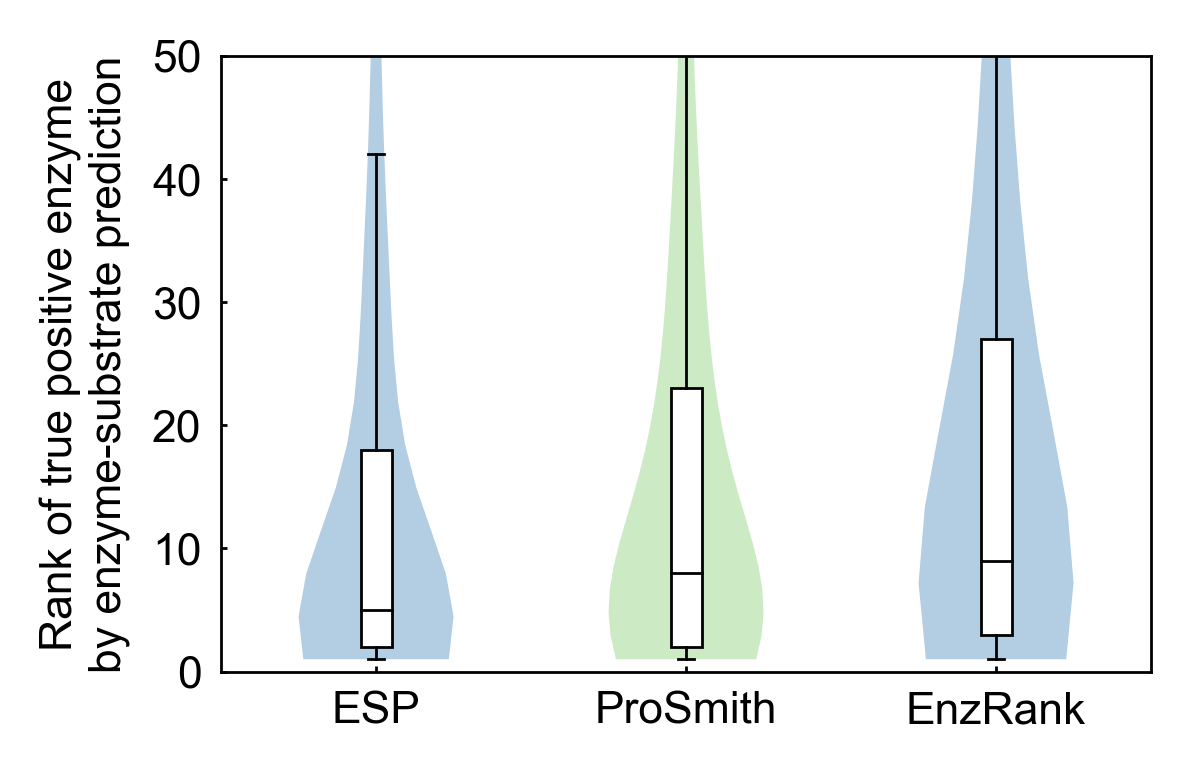

In [88]:
import matplotlib.pyplot as plt
import numpy as np

# 两组数据
medians = [np.median(esp_ranks), np.median(prosmith_ranks), np.median(enzrank_ranks)]
print('esp_ranks medians',medians[0])
print('prosmith_ranks medians',medians[1])
print('enzrank_ranks medians',medians[2])

# 通用设置
plt.figure(figsize=(3, 2), dpi=400)
plt.rcParams.update({'font.size': 8, 'font.family': 'Arial', 'pdf.fonttype': 42})

positions = [1, 2, 3]  # x轴位置
colors = ['#b3cde3', '#ccebc5', '#b3cde3']

for i, all_ranks in enumerate([esp_ranks, prosmith_ranks,enzrank_ranks]):
    # 小提琴图
    violin_parts = plt.violinplot(all_ranks, positions=[positions[i]], vert=True,
                                  showmeans=False, showmedians=False, bw_method=0.3)
    for part in violin_parts['bodies']:
        part.set_zorder(1)
        part.set_alpha(1)
        part.set_color(colors[i])
        part.set_linewidth(0)
    for partname in ('cbars', 'cmins', 'cmaxes'):
        violin_parts[partname].set_alpha(0)

    # 叠加箱线图
    plt.boxplot(all_ranks, positions=[positions[i]], widths=0.1, patch_artist=True, showfliers=False,
                boxprops=dict(facecolor='white', color='black', linewidth=0.5),
                medianprops=dict(color='black', linewidth=0.5),
                whiskerprops=dict(color='black', linewidth=0.5),
                capprops=dict(color='black', linewidth=0.5))

# 坐标轴和标签
plt.ylabel("Rank of true positive enzyme\nby enzyme-substrate prediction", fontsize=8)
plt.xticks(positions, ['ESP', 'ProSmith','EnzRank'], fontsize=8)
plt.xlim(0.5, 3.5)
plt.ylim(0, 50)
plt.tick_params(axis='both', direction='in', width=0.5, which='both', length=1)

for spine in plt.gca().spines.values():
    spine.set_linewidth(0.5)
plt.savefig(figs7_path, dpi=400, bbox_inches='tight')
plt.show()